<a href="https://colab.research.google.com/github/rajatb115/COL761_Data_Mining_Assignment1/blob/main/Part_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-geometric -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html

Looking in links: https://pytorch-geometric.com/whl/torch-+.html
  Created wheel for torch-scatter: filename=torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl size=282114 sha256=613bbef9c7a5d38f3b16945b61d7b8bfd4d7f2f1bc0bd20843b847cf8aa91f41
  Stored in directory: /root/.cache/pip/wheels/dd/57/a3/42ea193b77378ce634eb9454c9bc1e3163f3b482a35cdee4d1
Successfully built torch-scatter
Looking in links: https://pytorch-geometric.com/whl/torch-+.html
     |████████████████████████████████| 43 kB 846 kB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.12-cp37-cp37m-linux_x86_64.whl size=505740 sha256=13123dc6246062f1182b0aa15eb924e8c41da5f345629a6e8bf0de24db92e240
  Stored in directory: /root/.cache/pip/wheels/fb/e2/2f/44956c61e3299573ffe12da9d1374c7576ca0c5fb1fe1ed38c
Successfully built torch-sparse
Looking in links: https://pytorch-geometric.com/whl/torch-+.html
  Created wheel for torch-cluster: filename=torch_cluster-1.5.9-cp37-cp37m-linux_x86_64.whl size=317953 sha256=1c69fb74

In [ ]:
import torch
import torch.nn as nn
import networkx as nx
import numpy as np
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid

In [ ]:
dataset = Planetoid("","Cora",num_train_per_class= 150,split= 'random' ,num_test = 1000)

Processing...
Done!


In [ ]:
edges = dataset[0].edge_index
vertices = dataset[0].train_mask.shape[0]
edges = edges.T

In [ ]:
adjacency = np.zeros((vertices,vertices),dtype=np.float)
for edge in edges:
    adjacency[edge[0]][edge[1]] = 1.00
    adjacency[edge[1]][edge[0]] = 1.00

In [ ]:
diag = np.diag(np.sum(adjacency,axis=0))
Transition = np.dot(np.linalg.inv(diag),adjacency)

def matexpo(mat,power):
    result = np.identity(mat.shape[0])
    while (power!=0):
        result = np.dot(result,mat)
        power -= 1
    return result

Transition_fin = matexpo(Transition,0)+ matexpo(Transition,1) + matexpo(Transition,2) + matexpo(Transition,3)+ matexpo(Transition,4)
Transition_fin = Transition_fin / 5.00

In [ ]:
#Preparation of train_data
x_train = []
y_train = []
train_vertices = np.where(dataset[0].train_mask==True)
for i in range(0,len(train_vertices[0])):
    remaining= np.delete(train_vertices[0],i)
    store_vec = np.zeros(vertices)
    store_vec[train_vertices[0][i]]=1 
    distances = np.dot(Transition_fin,store_vec).reshape(-1)
 #   non_zero_sample = np.where(distances>0)
#    zero_sample =  np.where(distances==0)
 #   random_sample = np.concatenate((np.random.choice(non_zero_sample[0],5),np.random.choice(zero_sample[0],5)))
    for j in range(0,len(train_vertices[0])):
        x_train.append([train_vertices[0][i],train_vertices[0][j]])
        y_train.append(distances[train_vertices[0][j]])

x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
#Preparation of valid_data
x_val = []
y_val = []
val_vertices = np.where(dataset[0].val_mask==True)
for i in range(0,len(val_vertices[0])):
    remaining= np.delete(val_vertices[0],i)
    store_vec = np.zeros(vertices)
    store_vec[val_vertices[0][i]]=1 
    distances = np.dot(Transition_fin,store_vec).reshape(-1)
    non_zero_sample = np.where(distances>0)
    zero_sample =  np.where(distances==0)
    random_sample = np.concatenate((np.random.choice(non_zero_sample[0],5),np.random.choice(zero_sample[0],5)))
    for j in range(0,10):
        x_val.append([val_vertices[0][i],random_sample[j]])
        y_val.append(distances[random_sample[j]])

x_val = np.array(x_val)
y_val = np.array(y_val)

In [ ]:
#Preparation of test_data
x_test = []
y_test = []
test_vertices = np.where(dataset[0].test_mask==True)
for i in range(0,len(test_vertices[0])):
    remaining= np.delete(test_vertices[0],i)
    store_vec = np.zeros(vertices)
    store_vec[test_vertices[0][i]]=1 
    distances = np.dot(Transition_fin,store_vec).reshape(-1)
    non_zero_sample = np.where(distances>0)
    zero_sample =  np.where(distances==0)
    random_sample = np.concatenate((np.random.choice(non_zero_sample[0],5),np.random.choice(zero_sample[0],5)))
    for j in range(0,10):
        x_test.append([test_vertices[0][i],random_sample[j]])
        y_test.append(distances[random_sample[j]])

x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
from torch_geometric.nn import GATConv,GATv2Conv

class GAT(nn.Module):
    
    def __init__(self,hidden_dim,output_dim):
        super().__init__()
        self.conv1 = GATv2Conv(in_channels= -1, out_channels= 500,heads=4,concat=False)
        self.conv2 = GATv2Conv(in_channels= 500, out_channels= 250)      
    def forward(self,data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return x
   
class combined_model(nn.Module):
    def __init__(self,input_dim,hidden_dim):
        super().__init__()
        self.layer1 = GAT(200,100)
        self.mlp1 = nn.Linear(input_dim,hidden_dim)
        self.mlp2 = nn.Linear(hidden_dim,1)

    def forward(self,data,x):
        embeddings = self.layer1(data)
        x1 = torch.index_select(embeddings,0,x.T[0].flatten())
        y1 = torch.index_select(embeddings,0,x.T[1].flatten())
        store = torch.cat((x1,y1),dim=1)
        store = self.mlp1(store)
        store = F.relu(store)
        store = self.mlp2(store)
        store = F.relu(store)
        return store


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_fin = combined_model(500,400)
model_fin = model_fin.to(device)

In [ ]:
#Training and testing
data1 = dataset[0].to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model_fin.parameters(), lr=0.0001,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5, verbose=True)


epoch = 200
x_train_fin = torch.from_numpy(x_train)
x_train_fin = x_train_fin.to(device)
y_train_fin = torch.from_numpy(y_train)
y_train_fin = y_train_fin.to(device)

x_val_fin = torch.from_numpy(x_val)
x_val_fin = x_val_fin.to(device)
y_val_fin = torch.from_numpy(y_val)
y_val_fin = y_val_fin.to(device)

x_test_fin = torch.from_numpy(x_test)
x_test_fin = x_test_fin.to(device)
y_test_fin = torch.from_numpy(y_test)
y_test_fin = y_test_fin.to(device)

val_loss = None
val_acc = []
best_model = None
patience_count= 0

for i in range(0,epoch):
    pred_val = model_fin(data1,x_train_fin).flatten()
    y_train_fin= y_train_fin.float()
    loss1 = loss_func(pred_val,y_train_fin)
    print(f"Value of training loss for epoch {i} is: ",loss1.item())  
    optimizer.zero_grad()  
    loss1.backward()
    optimizer.step()

    
    pred_val = model_fin(data1,x_val_fin).flatten()
    y_val_fin = y_val_fin.float()
    loss1 = loss_func(pred_val,y_val_fin)
    val_acc.append(loss1.item())
    print(f"Value of validation loss for epoch {i} is: ",loss1.item())    
    if best_model is None:
        best_model = model_fin
        val_loss = loss1.item()
        patience_count = 0

    elif loss1.item() < val_loss:
        best_model = model_fin
        val_loss = loss1.item()
        patience_count = 0
    
    else:
        patience_count += 1

    if(patience_count == 10):
        patience_count = 0
        scheduler.step()

print("Training Done.")

Adjusting learning rate of group 0 to 1.0000e-04.
Value of training loss for epoch 0 is:  0.0024024778977036476
Value of validation loss for epoch 0 is:  0.007159412372857332
Value of training loss for epoch 1 is:  0.0016586726997047663
Value of validation loss for epoch 1 is:  0.0068598524667322636
Value of training loss for epoch 2 is:  0.0010673003271222115
Value of validation loss for epoch 2 is:  0.006701030768454075
Value of training loss for epoch 3 is:  0.0006227506091818213
Value of validation loss for epoch 3 is:  0.0066785383969545364
Value of training loss for epoch 4 is:  0.0003211184812244028
Value of validation loss for epoch 4 is:  0.006765737198293209
Value of training loss for epoch 5 is:  0.00015725877892691642
Value of validation loss for epoch 5 is:  0.0068530915305018425
Value of training loss for epoch 6 is:  0.00011097300739493221
Value of validation loss for epoch 6 is:  0.006891819182783365
Value of training loss for epoch 7 is:  0.00010885746451094747
Value o

KeyboardInterrupt: ignored

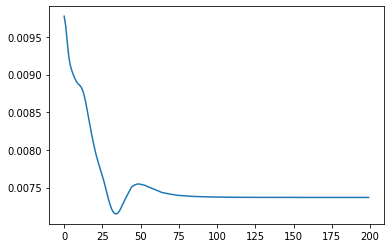

In [ ]:
import matplotlib.pyplot as plt
val_acc = np.array(val_acc)
x_axis = [i for i in range(0,200)]
plt.plot(x_axis,val_acc)
plt.show()

In [ ]:
pred_test = model_fin(data1,x_test_fin).flatten()
y_test_fin = y_test_fin.float()
loss1 = loss_func(pred_test,y_test_fin)
test_loss = loss1.item()
print("Loss on test data is: ",loss1.item())

Loss on test data is:  0.008047588169574738


PGNN attempt

In [ ]:
import random
import networkx as nx
import multiprocessing as mp

class PGNN_layer(nn.Module):
    def __init__(self, input_dim, output_dim,dist_trainable=True):
        super(PGNN_layer, self).__init__()
        self.input_dim = input_dim
        self.dist_trainable = dist_trainable

        if self.dist_trainable:
            self.dist_compute = Nonlinear(1, output_dim, 1)

        self.linear_hidden = nn.Linear(input_dim*2, output_dim)
        self.linear_out_position = nn.Linear(output_dim,1)
        self.act = nn.ReLU()

        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
                if m.bias is not None:
                    m.bias.data = nn.init.constant_(m.bias.data, 0.0)

    def forward(self, feature, dists_max, dists_argmax):
        if self.dist_trainable:
            dists_max = self.dist_compute(dists_max.unsqueeze(-1)).squeeze()

        subset_features = feature[dists_argmax.flatten(), :]
        subset_features = subset_features.reshape((dists_argmax.shape[0], dists_argmax.shape[1],
                                                   feature.shape[1]))
        messages = subset_features * dists_max.unsqueeze(-1)

        self_feature = feature.unsqueeze(1).repeat(1, dists_max.shape[1], 1)
        messages = torch.cat((messages, self_feature), dim=-1)

        messages = self.linear_hidden(messages).squeeze()
        messages = self.act(messages) # n*m*d

        out_position = self.linear_out_position(messages).squeeze(-1)  # n*m_out
        out_structure = torch.mean(messages, dim=1)  # n*d

        return out_position, out_structure


### Non linearity
class Nonlinear(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Nonlinear, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

        self.act = nn.ReLU()

        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
                if m.bias is not None:
                    m.bias.data = nn.init.constant_(m.bias.data, 0.0)

    def forward(self, x):
        x = self.linear1(x)
        x = self.act(x)
        x = self.linear2(x)
        return x


class PGNN(torch.nn.Module):
    def __init__(self, input_dim, feature_dim, hidden_dim, output_dim,
                 feature_pre=True, layer_num=2, dropout=True, **kwargs):
        super(PGNN, self).__init__()
        self.feature_pre = feature_pre
        self.layer_num = layer_num
        self.dropout = dropout
        if layer_num == 1:
            hidden_dim = output_dim
        if feature_pre:
            self.linear_pre = nn.Linear(input_dim, feature_dim)
            self.conv_first = PGNN_layer(feature_dim, hidden_dim)
        else:
            self.conv_first = PGNN_layer(input_dim, hidden_dim)
        if layer_num>1:
            self.conv_hidden = nn.ModuleList([PGNN_layer(hidden_dim, hidden_dim) for i in range(layer_num - 2)])
            self.conv_out = PGNN_layer(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        if self.feature_pre:
            x = self.linear_pre(x)
        x_position, x = self.conv_first(x, data.dists_max, data.dists_argmax)
        if self.layer_num == 1:
            return x_position
        # x = F.relu(x) # Note: optional!
        if self.dropout:
            x = F.dropout(x, training=self.training)
        for i in range(self.layer_num-2):
            _, x = self.conv_hidden[i](x, data.dists_max, data.dists_argmax)
            # x = F.relu(x) # Note: optional!
            if self.dropout:
                x = F.dropout(x, training=self.training)
        x_position, x = self.conv_out(x, data.dists_max, data.dists_argmax)
        x_position = F.normalize(x_position, p=2, dim=-1)
        return x_position

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data1 = dataset[0].to(device)

In [ ]:
def get_random_anchorset(n,c=0.5):
    m = int(np.log2(n))
    copy = int(c*m)
    anchorset_id = []
    for i in range(m):
        anchor_size = int(n/np.exp2(i + 1))
        for j in range(copy):
            anchorset_id.append(np.random.choice(n,size=anchor_size,replace=False))
    return anchorset_id

def get_dist_max(anchorset_id, dist, device):
    dist_max = torch.zeros((dist.shape[0],len(anchorset_id))).to(device)
    dist_argmax = torch.zeros((dist.shape[0],len(anchorset_id))).long().to(device)
    for i in range(len(anchorset_id)):
        temp_id = torch.as_tensor(anchorset_id[i], dtype=torch.long)
        dist_temp = dist[:, temp_id]
        dist_max_temp, dist_argmax_temp = torch.max(dist_temp, dim=-1)
        dist_max[:,i] = dist_max_temp
        dist_argmax[:,i] = temp_id[dist_argmax_temp]
    return dist_max, dist_argmax

def single_source_shortest_path_length_range(graph, node_range, cutoff):
    dists_dict = {}
    for node in node_range:
        dists_dict[node] = nx.single_source_shortest_path_length(graph, node, cutoff)
    return dists_dict

def merge_dicts(dicts):
    result = {}
    for dictionary in dicts:
        result.update(dictionary)
    return result

def all_pairs_shortest_path_length_parallel(graph,cutoff=None,num_workers=4):
    nodes = list(graph.nodes)
    random.shuffle(nodes)
    if len(nodes)<50:
        num_workers = int(num_workers/4)
    elif len(nodes)<400:
        num_workers = int(num_workers/2)

    pool = mp.Pool(processes=num_workers)
    results = [pool.apply_async(single_source_shortest_path_length_range,
            args=(graph, nodes[int(len(nodes)/num_workers*i):int(len(nodes)/num_workers*(i+1))], cutoff)) for i in range(num_workers)]
    output = [p.get() for p in results]
    dists_dict = merge_dicts(output)
    pool.close()
    pool.join()
    return dists_dict

def precompute_dist_data(edge_index, num_nodes, approximate=0):
        '''
        Here dist is 1/real_dist, higher actually means closer, 0 means disconnected
        :return:
        '''
        graph = nx.Graph()
        edge_list = edge_index.transpose(1,0).tolist()
        graph.add_edges_from(edge_list)

        n = num_nodes
        dists_array = np.zeros((n, n))
        # dists_dict = nx.all_pairs_shortest_path_length(graph,cutoff=approximate if approximate>0 else None)
        # dists_dict = {c[0]: c[1] for c in dists_dict}
        dists_dict = all_pairs_shortest_path_length_parallel(graph,cutoff=approximate if approximate>0 else None)
        for i, node_i in enumerate(graph.nodes()):
            shortest_dist = dists_dict[node_i]
            for j, node_j in enumerate(graph.nodes()):
                dist = shortest_dist.get(node_j, -1)
                if dist!=-1:
                    # dists_array[i, j] = 1 / (dist + 1)
                    dists_array[node_i, node_j] = 1 / (dist + 1)
        return dists_array

def preselect_anchor(data, layer_num=1, anchor_num=32, anchor_size_num=4, device='cpu'):

    data.anchor_size_num = anchor_size_num
    data.anchor_set = []
    data.dists_max = None
    data.dists_argmax = None
    anchor_num_per_size = anchor_num//anchor_size_num
    for i in range(anchor_size_num):
        anchor_size = 2**(i+1)-1
        anchors = np.random.choice(data.num_nodes, size=(layer_num,anchor_num_per_size,anchor_size), replace=True)
        data.anchor_set.append(anchors)
    data.anchor_set_indicator = np.zeros((layer_num, anchor_num, data.num_nodes), dtype=int)

    anchorset_id = get_random_anchorset(data.num_nodes,c=1)
    data.dists_max, data.dists_argmax = get_dist_max(anchorset_id, data.dists, device)
    return data

data2 = data1
data2.dists = torch.tensor(precompute_dist_data(data2.edge_index, data2.num_nodes ))
data2 = preselect_anchor(data2)

In [ ]:
class combined_model_2(nn.Module):
    def __init__(self,input_dim,hidden_dim):
        super().__init__()
        self.layer1 = PGNN(1433,100,500, 100)
        self.mlp1 = nn.Linear(input_dim,hidden_dim)
        self.mlp2 = nn.Linear(hidden_dim,1)

    def forward(self,data,x):
        embeddings = self.layer1(data)
        x1 = torch.index_select(embeddings,0,x.T[0].flatten())
        y1 = torch.index_select(embeddings,0,x.T[1].flatten())
        store = torch.cat((x1,y1),dim=1)
        store = self.mlp1(store)
        store = F.relu(store)
        store = self.mlp2(store)
        store = F.relu(store)
        return store

model_fin_2 = combined_model_2(242,400)
model_fin_2 = model_fin_2.to(device)



In [ ]:
optimizer_2 = torch.optim.Adam(model_fin_2.parameters(), lr=0.0001,weight_decay=1e-5)
scheduler_2 = torch.optim.lr_scheduler.ExponentialLR(optimizer_2, gamma=0.5, verbose=True)
loss_func = nn.MSELoss()
x_train_fin = torch.from_numpy(x_train)
x_train_fin = x_train_fin.to(device)
y_train_fin = torch.from_numpy(y_train)
y_train_fin = y_train_fin.to(device)

x_val_fin = torch.from_numpy(x_val)
x_val_fin = x_val_fin.to(device)
y_val_fin = torch.from_numpy(y_val)
y_val_fin = y_val_fin.to(device)

x_test_fin = torch.from_numpy(x_test)
x_test_fin = x_test_fin.to(device)
y_test_fin = torch.from_numpy(y_test)
y_test_fin = y_test_fin.to(device)

val_loss = None
val_acc = []
best_model = None
patience_count= 0
epoch = 100
for i in range(0,epoch):
    pred_val = model_fin_2(data2,x_train_fin).flatten()
    y_train_fin= y_train_fin.float()
    loss1 = loss_func(pred_val,y_train_fin)
    print(f"Value of training loss for epoch {i} is: ",loss1.item())  
    optimizer_2.zero_grad()  
    loss1.backward()
    optimizer_2.step()

    
    pred_val = model_fin_2(data1,x_val_fin).flatten()
    y_val_fin = y_val_fin.float()
    loss1 = loss_func(pred_val,y_val_fin)
    val_acc.append(loss1.item())
    print(f"Value of validation loss for epoch {i} is: ",loss1.item())    
    if best_model is None:
        best_model = model_fin_2
        val_loss = loss1.item()
        patience_count = 0

    elif loss1.item() < val_loss:
        best_model = model_fin_2
        val_loss = loss1.item()
        patience_count = 0
    
    else:
        patience_count += 1

    if(patience_count == 10):
        patience_count = 0
        scheduler_2.step()

print("Training Done.")

Adjusting learning rate of group 0 to 1.0000e-04.
